In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

import sys
sys.path.append('../')
from src import datasets, metrics
import mltrainer
mltrainer.__version__

'0.1.128'

In [2]:
trainfile = Path('../data/heart_train.parq').resolve()
testfile = Path('../data/heart_test.parq').resolve()
# trainfile = Path('../data/heart_big_train.parq').resolve()
# testfile = Path('../data/heart_big_test.parq').resolve()

Load the data

In [3]:
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")
traindataset, testdataset

# moving to mps device crashes the jypyter kernel, not sure why

(Heartdataset (len 11641), Heartdataset (len 2911))

Visualise it as 1D data

torch.Size([192, 1]) tensor(1)


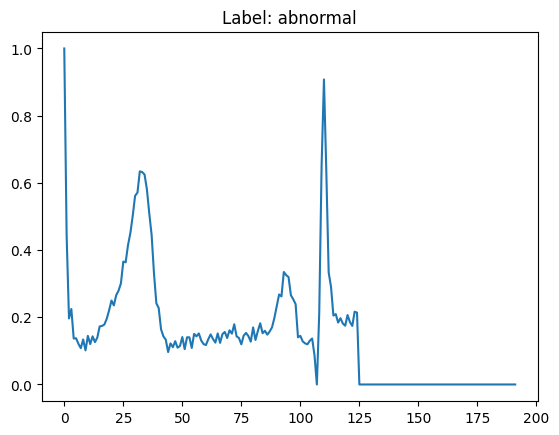

In [4]:
x, y = traindataset[0]
viz = x.squeeze().cpu().numpy()
sns.lineplot(x=range(len(viz)), y=viz)
title = 'normal' if y == 0 else 'abnormal'
plt.title(f"Label: {title}");
print(x.shape, y)

Set up the streamer

In [5]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(363, 90)

Positional encoding to use with the transformer.

In [6]:
from torch import Tensor
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_seq_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_seq_len, d_model)
        # batch, seq_len, d_model
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

Note, the layers have different assumptions about the data structure:
- streamer:         (batch, seq_len, channels)
- conv1d:           (batch, channels, seq_len)
- pos_encoding:     (batch, seq_len, channels)
- gru (batchfirst): (batch, seq_len, channels)
- attention:        (batch, seq_len, channels)

As you can see, its just the conv1d layer that expects channels as the second dimension. Using a conv1d layer you
will need to transpose the dimensions, I will show how to do that in the Transformer `forward` method.

Again, the strategy of creating a block helps us stack the architecture more easily.

In [7]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout):
        # feel free to change the input parameters of the constructor
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x):
        identity = x.clone() # skip connection
        x, _ = self.attention(x, x, x)
        x = self.layer_norm1(x + identity) # Add & Norm skip
        identity = x.clone() # second skip connection
        x = self.ff(x)
        x = self.layer_norm2(x + identity) # Add & Norm skip
        return x

class Transformer(nn.Module):
    def __init__(
        self,
        config: dict,
    ) -> None:
        super().__init__()
        self.conv1d = nn.Conv1d(
            in_channels=1,
            out_channels=config["hidden"],
            kernel_size=3,
            stride=2,
            padding=1,
        )
        self.pos_encoder = PositionalEncoding(config["hidden"], config["dropout"])

        # Create multiple transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(config["hidden"], config["num_heads"], config["dropout"])
            for _ in range(config["num_blocks"])
        ])

        self.out = nn.Linear(config["hidden"], config["output"])

    def forward(self, x: Tensor) -> Tensor:
        # streamer:         (batch, seq_len, channels)
        # conv1d:           (batch, channels, seq_len)
        # pos_encoding:     (batch, seq_len, channels)
        # attention:        (batch, seq_len, channels)
        x = self.conv1d(x.transpose(1, 2)) # flip channels and seq_len for conv1d
        x = self.pos_encoder(x.transpose(1, 2)) # flip back to seq_len and channels

        # Apply multiple transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        x = x.mean(dim=1) # Global Average Pooling
        x = self.out(x)
        return x

In [8]:
from src import models
config = {
    "hidden": 128,
    "dropout": 0.1,
    "output": 2,
    "num_heads": 4,
    "num_blocks": 3,
}
model = models.Transformer(config)

In [9]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 192, 1]), torch.Size([32]))

In [10]:
yhat = model(x)
yhat.shape

torch.Size([32, 2])

In [11]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [12]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("Transformer")

2024/06/18 17:48:10 INFO mlflow.tracking.fluent: Experiment with name 'Transformer' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/azureuser/code/mads-exam-24-FalcovdHoogen/notebooks/mlruns/2', creation_time=1718732890559, experiment_id='2', last_update_time=1718732890559, lifecycle_stage='active', name='Transformer', tags={}>

In [13]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="heart1D",
        train_steps=len(trainstreamer),
        valid_steps=len(teststreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()

2024-06-18 17:48:10.670 | INFO     | mltrainer.settings:check_path:61 - Created logdir /home/azureuser/code/mads-exam-24-FalcovdHoogen/notebooks/heart1D
2024-06-18 17:48:10.807 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to heart1D/20240618-174810
100%|██████████| 363/363 [00:34<00:00, 10.56it/s]
2024-06-18 17:48:49.473 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.4627 test 0.3497 metric ['0.8396', '0.8396', '0.8048', '0.8396', '0.8412']
100%|██████████| 363/363 [00:31<00:00, 11.43it/s]
2024-06-18 17:49:24.869 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3430 test 0.3052 metric ['0.8517', '0.8517', '0.8282', '0.8517', '0.8824']
100%|██████████| 363/363 [00:33<00:00, 10.78it/s]
2024-06-18 17:50:01.917 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.3120 test 0.2527 metric ['0.8924', '0.8924', '0.8697', '0.8924', '0.9079']
100%|██████████| 363/363 [00:32<00:00, 11.11it/s]
2024-06-18 17:50:37.855 | INFO     | mltrainer.trainer:re

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

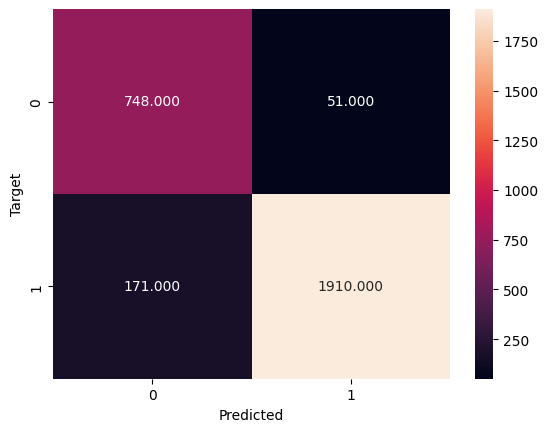

In [14]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
# cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")